# Black Hole Mass Predictor

## Import Libraries

In [51]:
from astropy.io import fits
from astropy.table import Table
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

## Read Data

In [2]:
fits_file = fits.open("data/DR16.fits")
fits_file_small = fits.open("data/DR16_Z.fits")

print(fits_file)

[<astropy.io.fits.hdu.image.PrimaryHDU object at 0x000001FCBA145AC0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x000001FCD8DF2390>]


In [3]:
DR16_fits = Table.read("data/DR16.fits")

print(DR16_fits)

   SDSS_NAME_1              RA_1         ...       Separation      
                                         ...         arcsec        
------------------ --------------------- ... ----------------------
000000.15+353104.2 0.0006294989251500738 ... 2.1615165486634594e-13
000000.33+310325.3 0.0014145086271355467 ...  1.442806039065566e-13
000000.36+070350.8 0.0015353689425410266 ...   9.50160001818925e-14
000000.36+274356.2 0.0015264841092630377 ...  1.200037972740516e-13
000000.45+092308.2 0.0019139323820809295 ... 1.0480352304269532e-13
000000.45+174625.4 0.0018982743563356053 ... 1.8633879837315987e-14
000000.47-002703.9  0.001978307141598634 ... 1.2299420115256465e-13
000000.57+055630.8 0.0023754761888312714 ...  2.557959443600196e-13
000000.62+311944.3 0.0025954542353474608 ...  1.874444456223307e-13
               ...                   ... ...                    ...
235959.64-044037.6    359.99853776089265 ...                    0.0
235959.70+084505.2     359.9987743613988 ...    

### Moving data from DR16_Z.fits to DR16_Z.csv

    import pandas as pd
    
    fits_file = 'DR16_Z.fits'
    
    csv_file = 'DR16_Zcsv.csv'
    
    
    with fits.open(fits_file) as hdul:
    
        hdul.info()
    
        data_hdu = hdul[1].data 
    
        df = pd.DataFrame(data_hdu)
    
        df.to_csv(csv_file, index=False)
    
    print(f"Data has been converted to a CSV File: {csv_file}")

### Renamed the DR16_Z.csv file DR16_small

In [4]:
file_bath = "data/DR16_Z.csv"

DR16_small = pd.read_csv(file_bath)

print(DR16_small.head())

          SDSS_NAME_1      RA_1      DEC_1         Z  GALEX_MATCHED       FUV  \
0  000000.33+310325.3  0.001415  31.057048  2.035491              1  0.279323   
1  000000.45+092308.2  0.001914   9.385637  2.024146              1  4.856251   
2  000000.45+174625.4  0.001898  17.773739  2.309000              1  0.302319   
3  000000.57+055630.8  0.002375   5.941903  2.102771              1  0.000000   
4  000000.66+145828.8  0.002756  14.974675  2.497000              1  0.046319   

        NUV  FIRST_MATCHED  FIRST_FLUX  XMM_SOFT_FLUX  ...  GAIA_G_MAG  \
0  0.165177              0        -1.0           -1.0  ...   -1.000000   
1  8.220212              0        -1.0           -1.0  ...   18.343128   
2  0.727565              0        -1.0           -1.0  ...   -1.000000   
3  0.000000              0        -1.0           -1.0  ...   -1.000000   
4  0.052530              0        -1.0           -1.0  ...   20.838264   

   GAIA_G_FLUX_SNR   Z_DR16Q     Z_FIT    LOGLBOL  LOGLBOL_ERR    LO

In [5]:
print(len(DR16_small.columns))

30


### Moving data from DR16.fits to DR16.csv

We need to decompose some columns in DR16 from 2D to 2D and 1D 

    from astropy.io import fits
    import pandas as pd
    
    fits_file = 'DR16.fits'
    
    csv_file = 'DR16csv.csv'
    
    
    with fits.open(fits_file) as hdul:
    
        hdul.info()
        
        data_hdu = hdul[1].data
        
        df = pd.DataFrame({col.name: data_hdu[col.name].tolist() 
                           if data_hdu[col.name].ndim > 1 else data_hdu[col.name]
                           for col in data_hdu.columns})
                           
        df.to_csv(csv_file, index=False)
    
    print(f"تم تحويل البيانات إلى ملف CSV: {csv_file}")

### Renamed the DR16csv.csv file to DR16_full

In [6]:
file_bath = "data/DR16.csv"

DR16_full = pd.read_csv(file_bath)

print(DR16_full.head())

          SDSS_NAME_1      RA_1      DEC_1  PLATE_1  MJD_1  FIBERID_1  \
0  000000.15+353104.2  0.000629  35.517841     7750  58402        802   
1  000000.33+310325.3  0.001415  31.057048     7749  58073        660   
2  000000.36+070350.8  0.001535   7.064129    11279  58449        978   
3  000000.36+274356.2  0.001526  27.732283     7695  57654        565   
4  000000.45+092308.2  0.001914   9.385637    11277  58450        705   

  AUTOCLASS_PQN AUTOCLASS_DR14Q  IS_QSO_QN      Z_QN  ...  LOGMBH_MGII_ERR  \
0           QSO             QSO          1  0.844138  ...         0.036066   
1           QSO             QSO          1  2.026023  ...        -1.000000   
2           QSO             QSO          1  1.565547  ...         0.355488   
3           QSO             QSO          1  1.774408  ...         0.115791   
4           QSO             QSO          1  2.033733  ...        -1.000000   

   LOGMBH_CIV  LOGMBH_CIV_ERR    LOGMBH  LOGMBH_ERR  LOGLEDD_RATIO  \
0    0.000000       -1

In [7]:
print("Numer of columns:",len(DR16_full.columns))

Numer of columns: 298


In [8]:
print("Numer of rows:",len(DR16_full))

Numer of rows: 750414


## Data Cleaning

### We want to make `HALPHA`, `HBETA`, `MGII`, `CIV` to Mean of them, in other solutions they take the first value, but we will rely on the Mean value

In [9]:
DR16_full["HALPHA"] = DR16_full["HALPHA"].apply(lambda x: sum(eval(x)) / len(eval(x)) if isinstance(x, str) else x)
DR16_full["HBETA"] = DR16_full["HBETA"].apply(lambda x: sum(eval(x)) / len(eval(x)) if isinstance(x, str) else x)
DR16_full["MGII"] = DR16_full["MGII"].apply(lambda x: sum(eval(x)) / len(eval(x)) if isinstance(x, str) else x)
DR16_full["CIV"] = DR16_full['CIV'].apply(lambda x: sum(eval(x)) / len(eval(x)) if isinstance(x, str) else x)

print(DR16_full[["HALPHA", "HBETA", "MGII", "CIV"]].head())

   HALPHA        HBETA         MGII          CIV
0     0.0  2860.773637  1934.062411     0.000000
1     0.0     0.000000  1695.081303  1755.282688
2     0.0     0.000000  1296.180491  1495.776835
3     0.0     0.000000  1998.729760  1888.465629
4     0.0     0.000000  1872.763237  1786.184013


### Cleaning the `LOGMBH` (target feature)

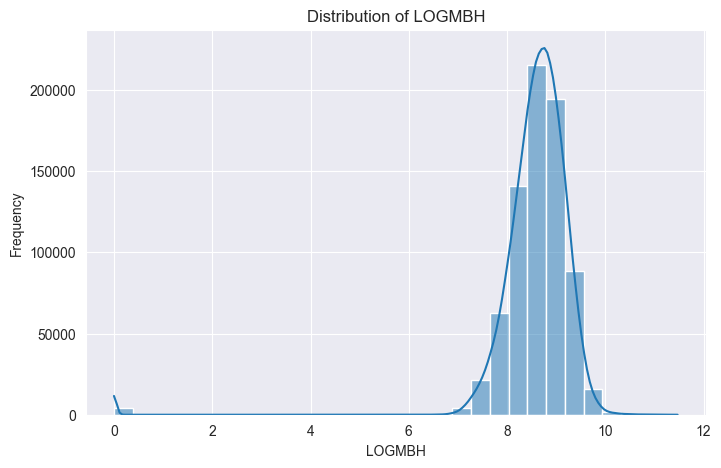

In [10]:
columns_to_plot = ["LOGMBH"]

for column in columns_to_plot:
    plt.figure(figsize=(8, 5))
    sns.histplot(DR16_full[column], kde=True, bins=30)
    plt.title(f"Distribution of {column}")
    plt.xlabel(column)
    plt.ylabel("Frequency")
    plt.show()

In [11]:
bins = [i * 0.25 for i in range(41)]

binned_counts = pd.cut(DR16_full["LOGMBH"], bins=bins, include_lowest=True).value_counts().sort_index()

print(binned_counts)

LOGMBH
(-0.001, 0.25]      4142
(0.25, 0.5]            0
(0.5, 0.75]            0
(0.75, 1.0]            0
(1.0, 1.25]            0
(1.25, 1.5]            0
(1.5, 1.75]            0
(1.75, 2.0]            0
(2.0, 2.25]            0
(2.25, 2.5]            0
(2.5, 2.75]            0
(2.75, 3.0]            0
(3.0, 3.25]            0
(3.25, 3.5]            1
(3.5, 3.75]            1
(3.75, 4.0]            0
(4.0, 4.25]            3
(4.25, 4.5]            2
(4.5, 4.75]            2
(4.75, 5.0]            4
(5.0, 5.25]            9
(5.25, 5.5]            5
(5.5, 5.75]            9
(5.75, 6.0]           15
(6.0, 6.25]            7
(6.25, 6.5]           31
(6.5, 6.75]          102
(6.75, 7.0]          646
(7.0, 7.25]         3535
(7.25, 7.5]        10404
(7.5, 7.75]        22454
(7.75, 8.0]        44106
(8.0, 8.25]        77658
(8.25, 8.5]       116027
(8.5, 8.75]       143819
(8.75, 9.0]       141225
(9.0, 9.25]       105662
(9.25, 9.5]        55658
(9.5, 9.75]        18957
(9.75, 10.0]      

In [12]:
DR16_full_filtered = DR16_full[(DR16_full["LOGMBH"] >= 7.75) & (DR16_full["LOGMBH"] <= 9.5)]

print(DR16_full_filtered.head())

print(f"Number of rows in filtered data: {DR16_full_filtered.shape[0]}")

          SDSS_NAME_1      RA_1      DEC_1  PLATE_1  MJD_1  FIBERID_1  \
0  000000.15+353104.2  0.000629  35.517841     7750  58402        802   
1  000000.33+310325.3  0.001415  31.057048     7749  58073        660   
2  000000.36+070350.8  0.001535   7.064129    11279  58449        978   
3  000000.36+274356.2  0.001526  27.732283     7695  57654        565   
5  000000.45+174625.4  0.001898  17.773739     7596  56945        162   

  AUTOCLASS_PQN AUTOCLASS_DR14Q  IS_QSO_QN      Z_QN  ...  LOGMBH_MGII_ERR  \
0           QSO             QSO          1  0.844138  ...         0.036066   
1           QSO             QSO          1  2.026023  ...        -1.000000   
2           QSO             QSO          1  1.565547  ...         0.355488   
3           QSO             QSO          1  1.774408  ...         0.115791   
5           QSO             QSO          1  2.309355  ...        -1.000000   

   LOGMBH_CIV  LOGMBH_CIV_ERR    LOGMBH  LOGMBH_ERR  LOGLEDD_RATIO  \
0    0.000000       -1

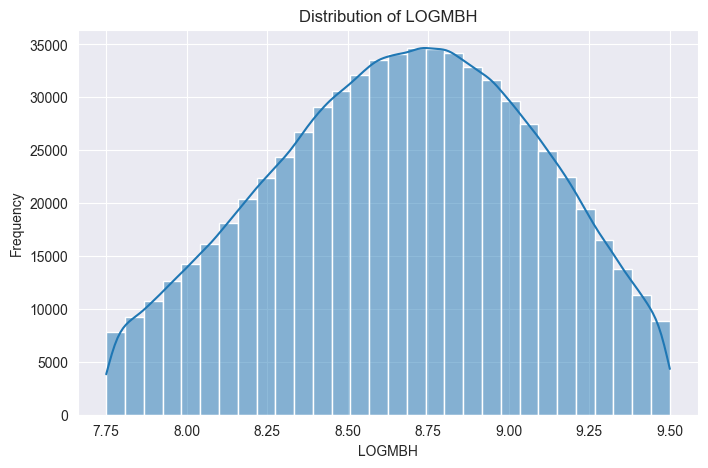

In [13]:
columns_to_plot = ["LOGMBH"]

for column in columns_to_plot:
    plt.figure(figsize=(8, 5))
    sns.histplot(DR16_full_filtered[column], kde=True, bins=30)
    plt.title(f"Distribution of {column}")
    plt.xlabel(column)
    plt.ylabel("Frequency")
    plt.show()

### Cleaning the `Z_DR16Q`

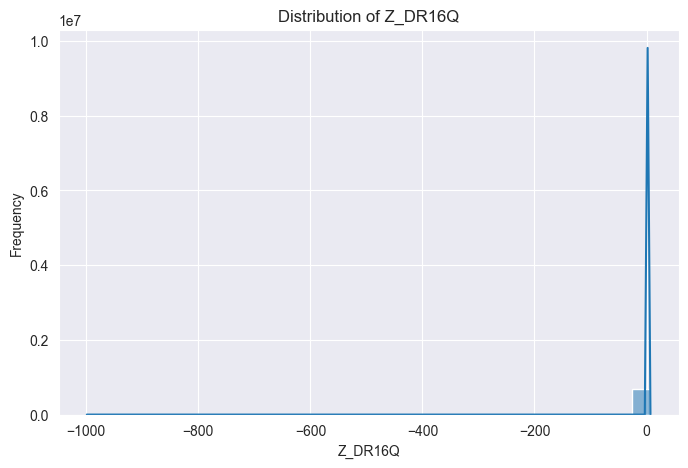

In [14]:
columns_to_plot = ["Z_DR16Q"]

for column in columns_to_plot:
    plt.figure(figsize=(8, 5))
    sns.histplot(DR16_full_filtered[column], kde=True, bins=30)
    plt.title(f"Distribution of {column}")
    plt.xlabel(column)
    plt.ylabel("Frequency")
    plt.show()

In [15]:
bins = [i * 0.25 for i in range(41)]

binned_counts = pd.cut(DR16_full_filtered['Z_DR16Q'], bins=bins, include_lowest=True).value_counts().sort_index()

print(binned_counts)

Z_DR16Q
(-0.001, 0.25]     1689
(0.25, 0.5]       12122
(0.5, 0.75]       36556
(0.75, 1.0]       63372
(1.0, 1.25]       75524
(1.25, 1.5]       87276
(1.5, 1.75]       88474
(1.75, 2.0]       77629
(2.0, 2.25]       71380
(2.25, 2.5]       70185
(2.5, 2.75]       42013
(2.75, 3.0]       24191
(3.0, 3.25]       17629
(3.25, 3.5]        7984
(3.5, 3.75]        3738
(3.75, 4.0]        2451
(4.0, 4.25]         908
(4.25, 4.5]         353
(4.5, 4.75]         183
(4.75, 5.0]         115
(5.0, 5.25]          83
(5.25, 5.5]          47
(5.5, 5.75]          72
(5.75, 6.0]          44
(6.0, 6.25]          24
(6.25, 6.5]          31
(6.5, 6.75]          33
(6.75, 7.0]          20
(7.0, 7.25]          26
(7.25, 7.5]           0
(7.5, 7.75]           0
(7.75, 8.0]           0
(8.0, 8.25]           0
(8.25, 8.5]           0
(8.5, 8.75]           0
(8.75, 9.0]           0
(9.0, 9.25]           0
(9.25, 9.5]           0
(9.5, 9.75]           0
(9.75, 10.0]          0
Name: count, dtype: int64


Take all data Z_DR16Q = (0.5, 3.0)

In [16]:
DR16_full_filtered = DR16_full_filtered[(DR16_full_filtered["Z_DR16Q"] >= 0.5) & (DR16_full_filtered["Z_DR16Q"] <= 3.0)]

print(DR16_full_filtered.head())

print(f"Number of rows in filtered data: {DR16_full_filtered.shape[0]}")

          SDSS_NAME_1      RA_1      DEC_1  PLATE_1  MJD_1  FIBERID_1  \
0  000000.15+353104.2  0.000629  35.517841     7750  58402        802   
1  000000.33+310325.3  0.001415  31.057048     7749  58073        660   
2  000000.36+070350.8  0.001535   7.064129    11279  58449        978   
3  000000.36+274356.2  0.001526  27.732283     7695  57654        565   
5  000000.45+174625.4  0.001898  17.773739     7596  56945        162   

  AUTOCLASS_PQN AUTOCLASS_DR14Q  IS_QSO_QN      Z_QN  ...  LOGMBH_MGII_ERR  \
0           QSO             QSO          1  0.844138  ...         0.036066   
1           QSO             QSO          1  2.026023  ...        -1.000000   
2           QSO             QSO          1  1.565547  ...         0.355488   
3           QSO             QSO          1  1.774408  ...         0.115791   
5           QSO             QSO          1  2.309355  ...        -1.000000   

   LOGMBH_CIV  LOGMBH_CIV_ERR    LOGMBH  LOGMBH_ERR  LOGLEDD_RATIO  \
0    0.000000       -1

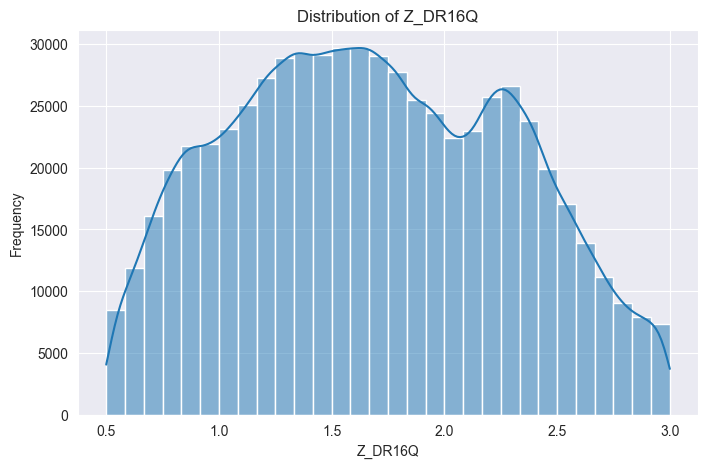

In [17]:
columns_to_plot = ["Z_DR16Q"]

for column in columns_to_plot:
    plt.figure(figsize=(8, 5))
    sns.histplot(DR16_full_filtered[column], kde=True, bins=30)
    plt.title(f"Distribution of {column}")
    plt.xlabel(column)
    plt.ylabel("Frequency")
    plt.show()

### Cleaning the `LOGMBH_ERR`

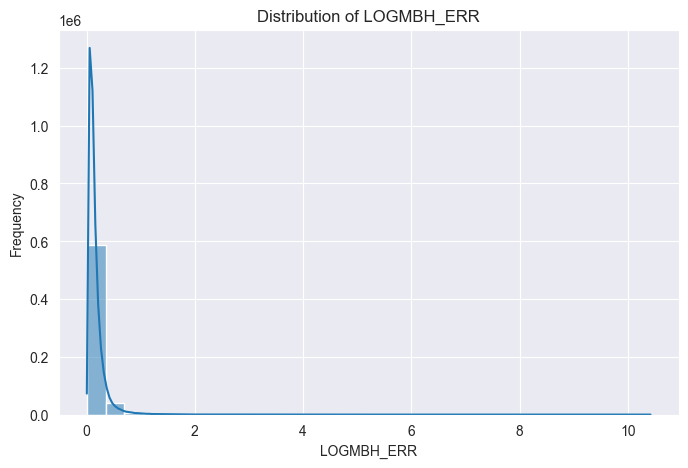

In [18]:
columns_to_plot = ["LOGMBH_ERR"]

for column in columns_to_plot:
    plt.figure(figsize=(8, 5))
    sns.histplot(DR16_full_filtered[column], kde=True, bins=30)
    plt.title(f"Distribution of {column}")
    plt.xlabel(column)
    plt.ylabel("Frequency")
    plt.show()

In [19]:
bins = [i * 0.1 for i in range(101)]

binned_counts = pd.cut(DR16_full_filtered["LOGMBH_ERR"], bins=bins, include_lowest=True).value_counts().sort_index()

print(binned_counts)

LOGMBH_ERR
(-0.001, 0.1]    268239
(0.1, 0.2]       220492
(0.2, 0.3]        79131
(0.3, 0.4]        32462
(0.4, 0.5]        14054
                  ...  
(9.5, 9.6]            0
(9.6, 9.7]            0
(9.7, 9.8]            0
(9.8, 9.9]            0
(9.9, 10.0]           0
Name: count, Length: 100, dtype: int64


In [20]:
DR16_full_filtered = DR16_full_filtered[(DR16_full_filtered["LOGMBH_ERR"] >= 0.3)]

print(DR16_full_filtered.head())

print(f"Number of rows in filtered data: {DR16_full_filtered.shape[0]}")

           SDSS_NAME_1      RA_1      DEC_1  PLATE_1  MJD_1  FIBERID_1  \
2   000000.36+070350.8  0.001535   7.064129    11279  58449        978   
10  000000.72+305758.5  0.003016  30.966277     7749  58073        360   
16  000001.23+360541.5  0.005141  36.094873     7750  58402        782   
56  000003.65+041456.3  0.015234   4.248977     8741  57390        973   
58  000003.82+250543.0  0.015928  25.095283     7666  57339        147   

   AUTOCLASS_PQN AUTOCLASS_DR14Q  IS_QSO_QN      Z_QN  ...  LOGMBH_MGII_ERR  \
2            QSO             QSO          1  1.565547  ...         0.355488   
10           QSO             QSO          1  1.636826  ...         0.322852   
16           QSO             QSO          1  1.610150  ...         0.796113   
56           QSO             QSO          1  2.742998  ...        -1.000000   
58           QSO             QSO          1  1.443978  ...         1.063133   

    LOGMBH_CIV  LOGMBH_CIV_ERR    LOGMBH  LOGMBH_ERR  LOGLEDD_RATIO  \
2     0.0

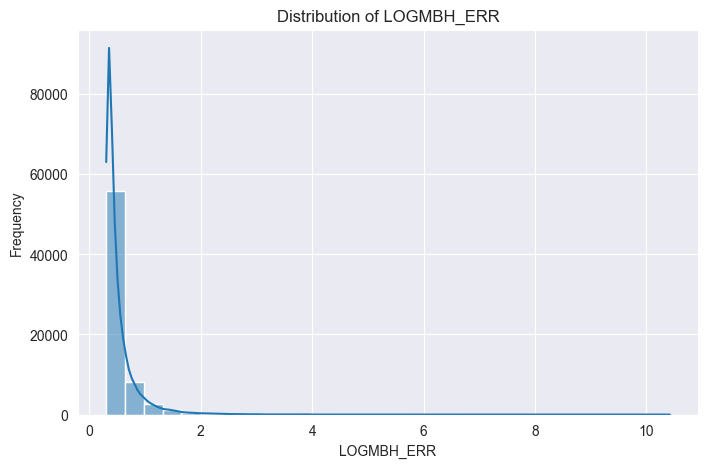

In [21]:
columns_to_plot = ["LOGMBH_ERR"]

for column in columns_to_plot:
    plt.figure(figsize=(8, 5))
    sns.histplot(DR16_full_filtered[column], kde=True, bins=30)
    plt.title(f"Distribution of {column}")
    plt.xlabel(column)
    plt.ylabel("Frequency")
    plt.show()

In [22]:
print(len(DR16_full_filtered))

68757


## Columns and Rows

### Columns

In [23]:
for column in DR16_full_filtered.columns:
    print(column)

SDSS_NAME_1
RA_1
DEC_1
PLATE_1
MJD_1
FIBERID_1
AUTOCLASS_PQN
AUTOCLASS_DR14Q
IS_QSO_QN
Z_QN
RANDOM_SELECT
Z_10K
Z_CONF_10K
PIPE_CORR_10K
IS_QSO_10K
THING_ID
Z_VI
Z_CONF
CLASS_PERSON
Z_DR12Q
IS_QSO_DR12Q
Z_DR7Q_SCH
IS_QSO_DR7Q
Z_DR6Q_HW
Z_DR7Q_HW
IS_QSO_FINAL
Z
SOURCE_Z
Z_PIPE
ZWARNING
OBJID_1
Z_PCA
ZWARN_PCA
DELTACHI2_PCA
Z_HALPHA
ZWARN_HALPHA
DELTACHI2_HALPHA
Z_HBETA
ZWARN_HBETA
DELTACHI2_HBETA
Z_MGII
ZWARN_MGII
DELTACHI2_MGII
Z_CIII
ZWARN_CIII
DELTACHI2_CIII
Z_CIV
ZWARN_CIV
DELTACHI2_CIV
Z_LYA
ZWARN_LYA
DELTACHI2_LYA
Z_LYAWG
Z_DLA
NHI_DLA
CONF_DLA
BAL_PROB
BI_CIV
ERR_BI_CIV
AI_CIV
ERR_AI_CIV
BI_SIIV
ERR_BI_SIIV
AI_SIIV
ERR_AI_SIIV
BOSS_TARGET1
EBOSS_TARGET0
EBOSS_TARGET1
EBOSS_TARGET2
ANCILLARY_TARGET1
ANCILLARY_TARGET2
NSPEC_SDSS
NSPEC_BOSS
NSPEC
PLATE_DUPLICATE
MJD_DUPLICATE
FIBERID_DUPLICATE
SPECTRO_DUPLICATE
SKYVERSION
RUN_NUMBER
RERUN_NUMBER
CAMCOL_NUMBER
FIELD_NUMBER
ID_NUMBER
LAMBDA_EFF
ZOFFSET
XFOCAL
YFOCAL
CHUNK
TILE
PLATESN2
PSFFLUX
PSFFLUX_IVAR
PSFMAG
PSFMAGERR
EXTINCTION


1) Z_DR16Q:

    الانزياح الأحمر (Redshift) المقدم من DR16Q.
    
    يمثل مقدار تمدد الضوء أثناء انتقاله من الجرم السماوي إلينا، وهو مؤشر للمسافة الكونية.
   

2) LOGMBH_HB, LOGMBH_MGII, LOGMBH_CIV: LOGLBOL

    كتلة الثقب الأسود (Black Hole Mass) محسوبة باستخدام خطوط Hβ، Mg II، و C IV.
    
    هذه الأعمدة تمثل حسابات الكتلة بناءً على خطوط الانبعاث المختلفة.


4) LOGMBH:

    الكتلة المرجعية أو النهائية للثقب الأسود (Fiducial Black Hole Mass).
    
    غالبًا ما تُعتبر المتوسط أو التقدير الأفضل.


5) LOGL5100, LOGL3000, LOGL1350:

    اللمعان (Luminosity) عند أطوال موجية معينة: 5100 Å، 3000 Å، و 1350 Å.
    
    تُستخدم هذه القيم لتقدير نشاط الجرم السماوي.


6) HBETA, MGII, CIV:

    خطوط انبعاث الطيف مثل Hβ، Mg II، و C IV.
    
    تُستخدم هذه الأعمدة لتحليل حركة الغاز وخصائص الثقب الأسود. (تحتوي على قوائم بيانات متعددة).


7) LOGMBH_HB_ERR, LOGMBH_MGII_ERR, LOGMBH_CIV_ERR, LOGMBH_ERR: LOGLOBOL_ERR

    الأخطاء المرتبطة بتقدير الكتلة باستخدام كل خط انبعاث أو كتلة الثقب المرجعية.
    
    تُظهر مدى دقة القياسات.


8) GAIA_G_FLUX_SNR, GAIA_BP_FLUX_SNR:

        نسبة الإشارة إلى الضوضاء (Signal-to-Noise Ratio) لمقاييس مختلفة.
        
        تُظهر جودة البيانات الطيفية لكل نطاق.
        8) GAIA_G_FLUX_SNR, GAIA_BP_FLUX_SNR,
            8) الاحمر الى الاخضرو ما بعد ذلك \


    

In [24]:
selected_columns = ["Z_DR16Q","LOGMBH_HB", "LOGMBH_MGII", "LOGMBH_CIV", "LOGMBH","LOGL5100", "LOGL3000", "LOGL1350","HBETA",
                    "MGII", "CIV","LOGMBH_HB_ERR", "LOGMBH_MGII_ERR", "LOGMBH_CIV_ERR", "LOGMBH_ERR","GAIA_G_FLUX_SNR", "GAIA_BP_FLUX_SNR"]

DR16_full_filtered_columns = DR16_full_filtered[selected_columns]

print(DR16_full_filtered_columns.columns)

Index(['Z_DR16Q', 'LOGMBH_HB', 'LOGMBH_MGII', 'LOGMBH_CIV', 'LOGMBH',
       'LOGL5100', 'LOGL3000', 'LOGL1350', 'HBETA', 'MGII', 'CIV',
       'LOGMBH_HB_ERR', 'LOGMBH_MGII_ERR', 'LOGMBH_CIV_ERR', 'LOGMBH_ERR',
       'GAIA_G_FLUX_SNR', 'GAIA_BP_FLUX_SNR'],
      dtype='object')


In [ ]:
df = pd.DataFrame(DR16_full_filtered_columns)

df.to_csv("data/clean.csv", index=False)

In [4]:
DR16_full_filtered_columns = pd.read_csv("data/clean.csv")

print(DR16_full_filtered_columns["LOGMBH"].head())

0    8.065870
1    9.108047
2    8.233579
3    7.933868
4    7.879703
Name: LOGMBH, dtype: float64


### Rows

In [5]:
DR16_full_columns_rows = DR16_full_filtered_columns.sample(n=2000, random_state=42)

print("Number of rows",len(DR16_full_columns_rows))

Number of rows 2000


In [27]:
print(len(DR16_full_filtered_columns))

68757


## Data Charts

### Univariate Distribution (التوزيع الأحادي)
see the frequency for any column

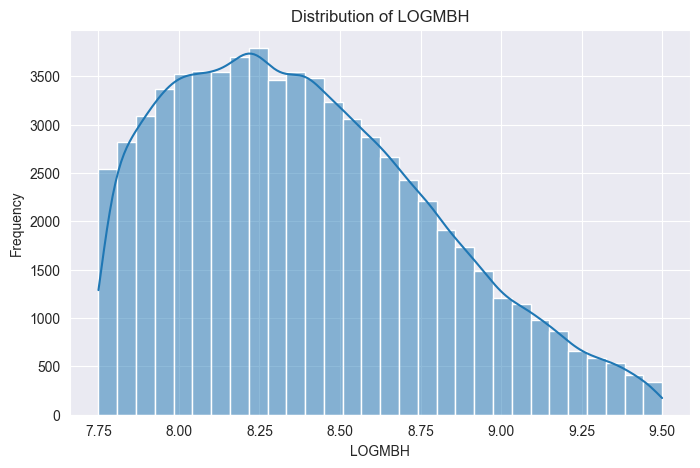

In [28]:
columns_to_plot = ["LOGMBH"]

for column in columns_to_plot:
    plt.figure(figsize=(8, 5))
    sns.histplot(DR16_full_filtered_columns[column], kde=True, bins=30)
    plt.title(f"Distribution of {column}")
    plt.xlabel(column)
    plt.ylabel("Frequency")
    plt.show()

 ### Bivariate Relationships (العلاقات الثنائية)
see the conaction for any two column

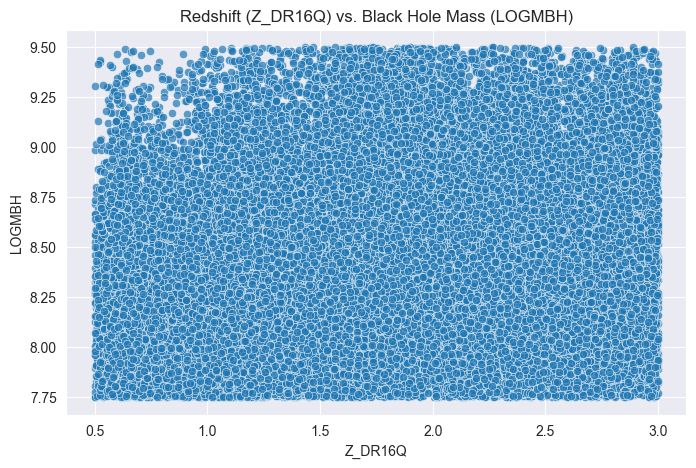

In [29]:
plt.figure(figsize=(8, 5))
sns.scatterplot(x="Z_DR16Q", y="LOGMBH", data=DR16_full_filtered_columns, alpha=0.7)
plt.title("Redshift (Z_DR16Q) vs. Black Hole Mass (LOGMBH)")
plt.xlabel("Z_DR16Q")
plt.ylabel("LOGMBH")
plt.show()

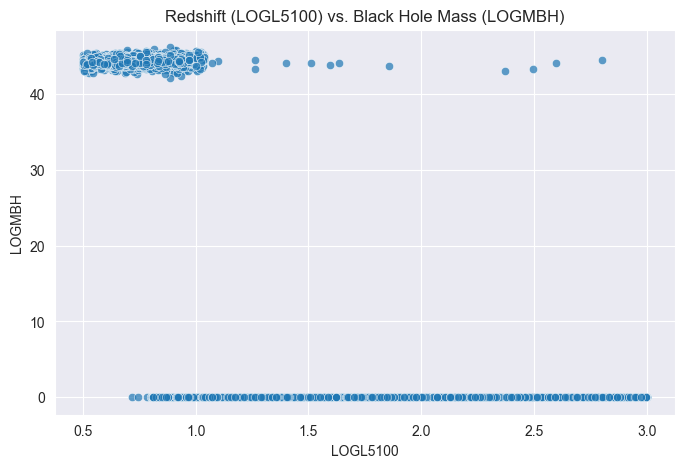

In [30]:
plt.figure(figsize=(8, 5))
sns.scatterplot(x="Z_DR16Q", y="LOGL5100", data=DR16_full_filtered_columns, alpha=0.7)
plt.title("Redshift (LOGL5100) vs. Black Hole Mass (LOGMBH)")
plt.xlabel("LOGL5100")
plt.ylabel("LOGMBH")
plt.show()

 ### Correlation (الارتباط)
Explain the extent of the relationship between the columns

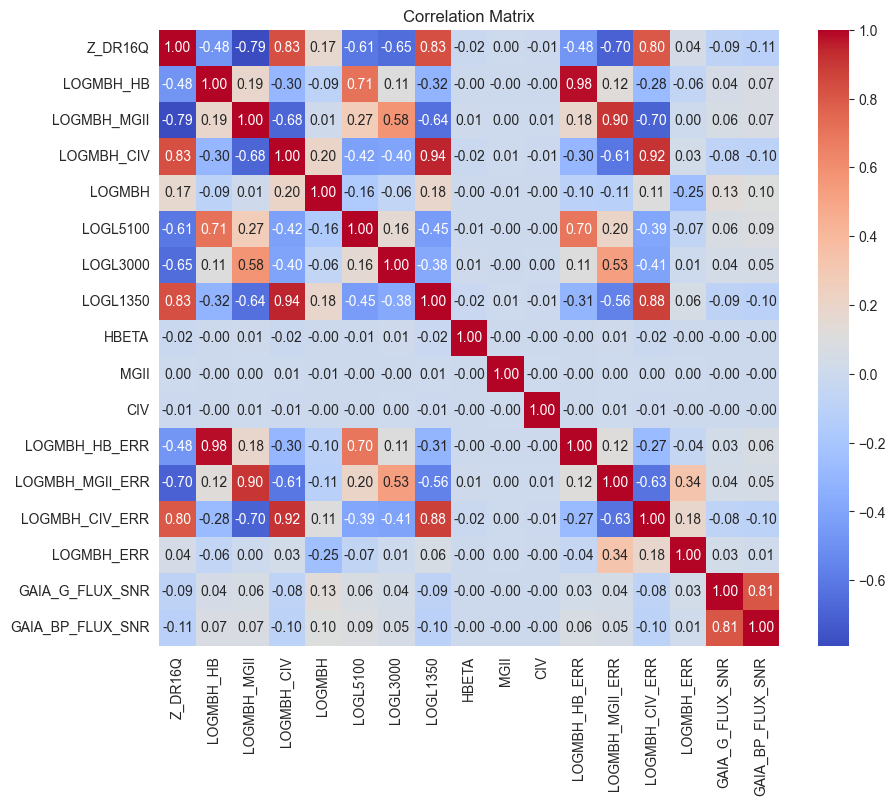

In [31]:
correlation_matrix = DR16_full_filtered_columns.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

### Multivariate Relationships (المقارنة بين الأعمدة)
Comparison of columns

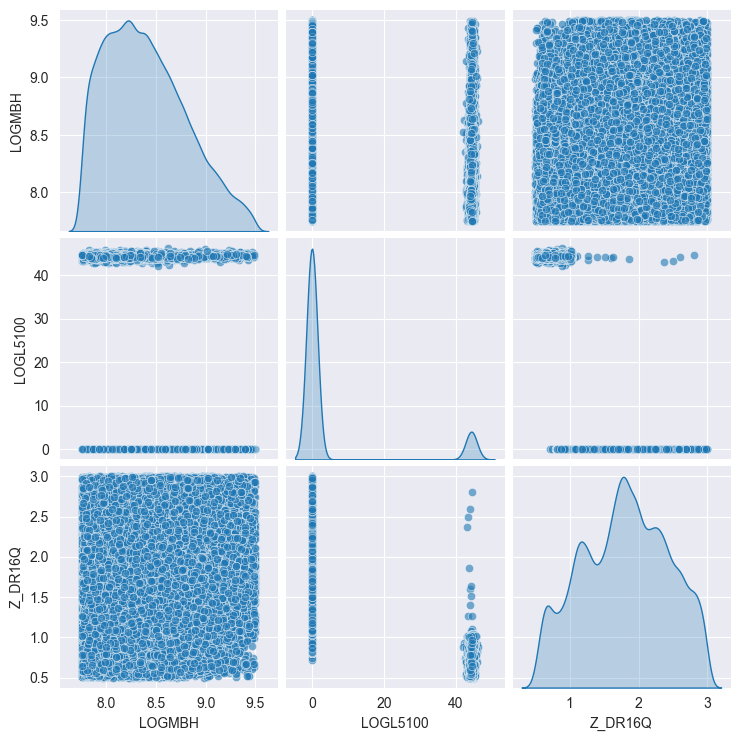

In [32]:
columns_to_pairplot = ["LOGMBH", "LOGL5100", "Z_DR16Q"]
sns.pairplot(DR16_full_filtered_columns[columns_to_pairplot], diag_kind="kde", plot_kws={"alpha": 0.6})
plt.show()

### 3D Charts

#### 3D plotting: `Z_DR16Q`, `LOGMBH`, `LOGL5100`

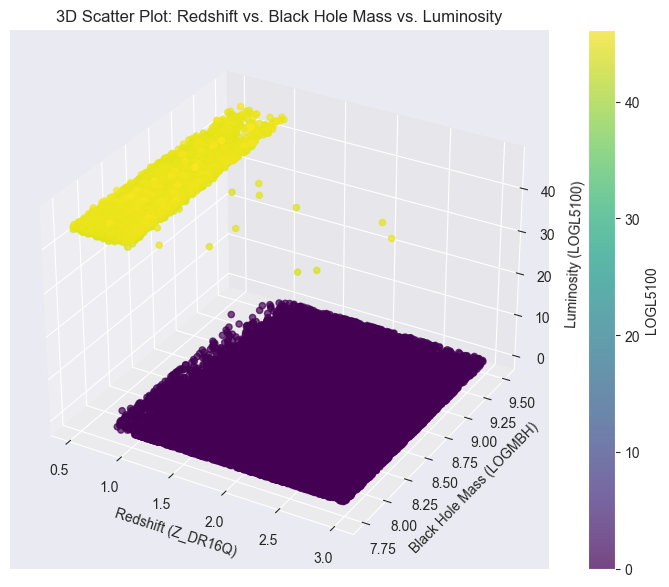

In [33]:
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection="3d")

sc = ax.scatter(DR16_full_filtered_columns["Z_DR16Q"],
                DR16_full_filtered_columns["LOGMBH"],
                DR16_full_filtered_columns["LOGL5100"],
                c=DR16_full_filtered_columns["LOGL5100"],
                cmap="viridis",
                alpha=0.7)

ax.set_xlabel("Redshift (Z_DR16Q)")
ax.set_ylabel("Black Hole Mass (LOGMBH)")
ax.set_zlabel("Luminosity (LOGL5100)")

plt.colorbar(sc, label="LOGL5100")
plt.title("3D Scatter Plot: Redshift vs. Black Hole Mass vs. Luminosity")
plt.show()

#### 3D plotting: `Z_DR16Q`, `LOGMBH`, `GAIA_G_FLUX_SNR`

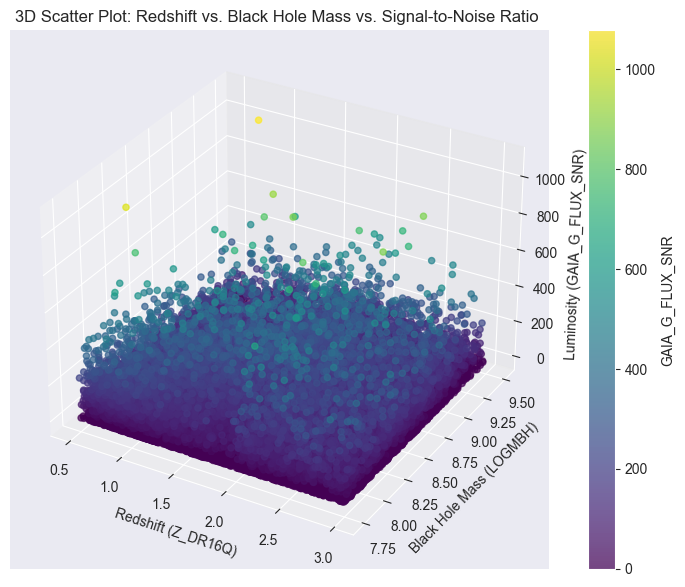

In [34]:
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection="3d")

sc = ax.scatter(DR16_full_filtered_columns["Z_DR16Q"],
                DR16_full_filtered_columns["LOGMBH"],
                DR16_full_filtered_columns["GAIA_G_FLUX_SNR"],
                c=DR16_full_filtered_columns["GAIA_G_FLUX_SNR"],
                cmap="viridis",
                alpha=0.7)

ax.set_xlabel("Redshift (Z_DR16Q)")
ax.set_ylabel("Black Hole Mass (LOGMBH)")
ax.set_zlabel("Luminosity (GAIA_G_FLUX_SNR)")

plt.colorbar(sc, label="GAIA_G_FLUX_SNR")
plt.title("3D Scatter Plot: Redshift vs. Black Hole Mass vs. Signal-to-Noise Ratio ")
plt.show()

## Laws to Extract The Value of The Mass of a Black Hole

### *M_BH = f .(2 ^ ( FWHM_HB / 1000 )) . (0.5 ^ ( L_5100 / 10 ^ 44))*

In [35]:
FWHM_Hb = 4000
L_5100 = 2e44

log_M_BH = 6.91 + 2 * np.log10(FWHM_Hb / 1000) + 0.5 * np.log10(L_5100 / 1e44)
M_BH = 10**log_M_BH

print(f"Black Hole Mass: {M_BH:.2e} M_sun")

Black Hole Mass: 1.84e+08 M_sun


### *M_BH = A + B * log10( FWHM / 1000 ) + C * log10( L / 10 ^ 44)*

In [36]:
B = 2.0
ABH, CBH = 6.91, 0.5
AMGII, CMGII = 6.86, 0.5
ACIV, CCIV = 6.71, 0.53

input = 10

LOGMBH = DR16_full_filtered_columns["LOGMBH"].iloc[input]
LOGMBH_HB = DR16_full_filtered_columns["LOGMBH_HB"].iloc[input]
LOGMBH_MGII = DR16_full_filtered_columns["LOGMBH_MGII"].iloc[input]
LOGMBH_CIV = DR16_full_filtered_columns["LOGMBH_CIV"].iloc[input]

FWHM_HB = DR16_full_filtered_columns["HBETA"].iloc[input]
FWHM_MGII = DR16_full_filtered_columns["MGII"].iloc[input]
FWHM_CIV = DR16_full_filtered_columns["CIV"].iloc[input]

L_5100 = DR16_full_filtered_columns["LOGL5100"].iloc[input]
L_3000 = DR16_full_filtered_columns["LOGL3000"].iloc[input]
L_1350 = DR16_full_filtered_columns["LOGL1350"].iloc[input]

def calculate_mass(A, B, C, FWHM, L):
    if FWHM > 0 and L > 0:
        log_mass = A + B * np.log10(FWHM / 1000) + C * np.log10(10 ** (L - 44))
        mass = 10**log_mass
        return log_mass, mass
    else:
        return None, None

log_M_BH, M_BH = calculate_mass(ABH, B, CBH, FWHM_HB, L_5100)

log_M_MGII, M_MGII = calculate_mass(AMGII, B, CMGII, FWHM_MGII, L_3000)

log_M_CIV, M_CIV = calculate_mass(ACIV, B, CCIV, FWHM_CIV, L_1350)

if log_M_BH :
    print(f"LOGMBH: {log_M_BH:.4f}")
    print(f"Mass of Black Hole (M_BH): {M_BH:.2e} M_sun")
print("LOGMBH_HB: ",LOGMBH_HB)
if log_M_MGII:
    print(f"LOGMMGII: {log_M_MGII:.4f}")
    print(f"Mass of Black Hole (M_MGII): {M_MGII:.2e} M_sun")
print("LOGMBH_MGII: ",LOGMBH_MGII)
if log_M_CIV:
    print(f"LOGMCIV: {log_M_CIV:.4f}")
    print(f"Mass of Black Hole (M_CIV): {M_CIV:.2e} M_sun")
print("LOGMBH_CIV: ",LOGMBH_CIV)
print("LOGMBH: ",LOGMBH)

LOGMBH: 7.4854
Mass of Black Hole (M_BH): 3.06e+07 M_sun
LOGMBH_HB:  0.0
LOGMMGII: 7.1707
Mass of Black Hole (M_MGII): 1.48e+07 M_sun
LOGMBH_MGII:  7.771977056541667
LOGMBH_CIV:  0.0
LOGMBH:  7.771977056541667


## Training Data

### Split test, validation and train datasets

- Training: 70%
- Validation: 15%
- Test: 15%

In [6]:
X = DR16_full_filtered_columns.drop(columns=["LOGMBH"])
y = DR16_full_filtered_columns["LOGMBH"]

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print("Training set size:", X_train.shape)
print("Validation set size:", X_val.shape)
print("Test set size:", X_test.shape)

Training set size: (48129, 16)
Validation set size: (10314, 16)
Test set size: (10314, 16)


In [7]:
print(np.isnan(X_train).sum())

print(np.isnan(y_train).sum())

Z_DR16Q             0
LOGMBH_HB           0
LOGMBH_MGII         0
LOGMBH_CIV          0
LOGL5100            0
LOGL3000            0
LOGL1350            0
HBETA               0
MGII                0
CIV                 0
LOGMBH_HB_ERR       0
LOGMBH_MGII_ERR     0
LOGMBH_CIV_ERR      0
LOGMBH_ERR          0
GAIA_G_FLUX_SNR     0
GAIA_BP_FLUX_SNR    0
dtype: int64
0


In [8]:
X_train = np.where(np.isinf(X_train), np.nan, X_train)
X_test = np.where(np.isinf(X_test), np.nan, X_test)
X_val = np.where(np.isinf(X_val), np.nan, X_val)

X_train = np.nan_to_num(X_train, nan=np.nanmean(X_train))
X_test = np.nan_to_num(X_test, nan=np.nanmean(X_test))
X_val = np.nan_to_num(X_val, nan=np.nanmean(X_val))

In [9]:
max_limit = 1e10

X_train = np.clip(X_train, -max_limit, max_limit)
X_temp = np.clip(X_temp, -max_limit, max_limit)
X_test = np.clip(X_test, -max_limit, max_limit)

In [10]:
print(np.isnan(X_train).sum())

print(np.isnan(y_train).sum())

0
0


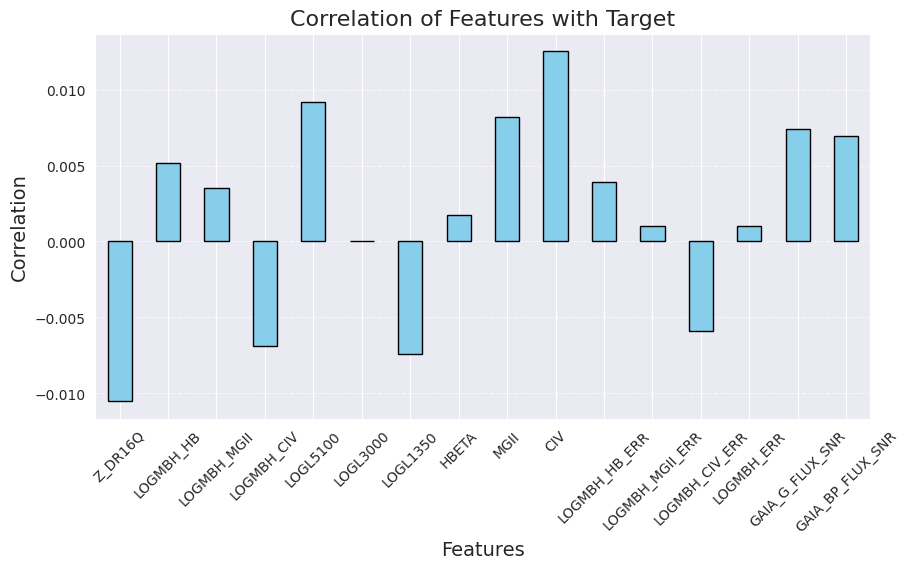

In [24]:
X_train_df = pd.DataFrame(X_train, columns=DR16_full_filtered_columns.drop(columns=["LOGMBH"]).columns)

y_train_series = pd.Series(y_train, name="Target")

correlation_matrix = X_train_df.corrwith(y_train_series)

plt.figure(figsize=(10, 5))
correlation_matrix.plot(kind="bar", color="skyblue", edgecolor="black")
plt.title("Correlation of Features with Target", fontsize=16)
plt.xlabel("Features", fontsize=14)
plt.ylabel("Correlation", fontsize=14)
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

## Modeling
1. Linear Regression
2. Lasso Regression (L1 Regularization)
3. Ridge Regression (L2 Regularization)
4. Random Forest Regression

### Linear Regression

In [52]:
linear_regression = LinearRegression()

linear_regression.fit(X_train, y_train)

linear_regression_y_val_pred = linear_regression.predict(X_val)
linear_regression_y_test_pred = linear_regression.predict(X_test)

linear_regression_mse_val = mean_squared_error(y_val, linear_regression_y_val_pred)
linear_regression_mse_test = mean_squared_error(y_test, linear_regression_y_test_pred)

linear_regression_r2_val = r2_score(y_val, linear_regression_y_val_pred)
linear_regression_r2_test = r2_score(y_test, linear_regression_y_test_pred)


linear_regression_results = {"Model": "Linear Regression",
                             "Validation MSE": linear_regression_mse_val,
                             "Test MSE": linear_regression_mse_test,
                             "Validation R^2": linear_regression_r2_val,
                             "Test R^2": linear_regression_r2_test}

linear_regression_results_df = pd.DataFrame([linear_regression_results])

print(linear_regression_results_df)

               Model  Validation MSE  Test MSE  Validation R^2  Test R^2
0  Linear Regression        0.678484  0.135274       -3.210615   0.17398


### Lasso Regression

In [53]:
lasso_regression = Lasso(alpha=0.4)

lasso_regression.fit(X_train, y_train)

lasso_regression_y_val_pred = lasso_regression.predict(X_val)
lasso_regression_y_test_pred = lasso_regression.predict(X_test)

lasso_regression_mse_val = mean_squared_error(y_val, lasso_regression_y_val_pred)
lasso_regression_mse_test = mean_squared_error(y_test, lasso_regression_y_test_pred)

lasso_regression_r2_val = r2_score(y_val, lasso_regression_y_val_pred)
lasso_regression_r2_test = r2_score(y_test, lasso_regression_y_test_pred)


lasso_regression_results = {"Model": "Lasso Regression",
                            "Validation MSE": lasso_regression_mse_val,
                            "Test MSE": lasso_regression_mse_test,
                            "Validation R^2": lasso_regression_r2_val,
                            "Test R^2": lasso_regression_r2_test}

lasso_regression_results_df = pd.DataFrame([lasso_regression_results])

print(lasso_regression_results_df)

              Model  Validation MSE  Test MSE  Validation R^2  Test R^2
0  Lasso Regression        4.491126  0.154288      -26.871544  0.057876


### Ridge Regression

In [54]:
ridge_regression = Ridge(alpha=0.3)

ridge_regression.fit(X_train, y_train)

ridge_regression_y_val_pred = ridge_regression.predict(X_val)
ridge_regression_y_test_pred = ridge_regression.predict(X_test)

ridge_regression_mse_val = mean_squared_error(y_val, ridge_regression_y_val_pred)
ridge_regression_mse_test = mean_squared_error(y_test, ridge_regression_y_test_pred)

ridge_regression_r2_val = r2_score(y_val, ridge_regression_y_val_pred)
ridge_regression_r2_test = r2_score(y_test, ridge_regression_y_test_pred)


ridge_regression_results = {"Model": "Ridge Regression",
                            "Validation MSE": ridge_regression_mse_val,
                            "Test MSE": ridge_regression_mse_test,
                            "Validation R^2": ridge_regression_r2_val,
                            "Test R^2": ridge_regression_r2_test}

ridge_regression_results_df = pd.DataFrame([ridge_regression_results])

print(ridge_regression_results_df)

              Model  Validation MSE  Test MSE  Validation R^2  Test R^2
0  Ridge Regression        0.677939  0.135274        -3.20723  0.173983


### Random Forest Regression

In [55]:
random_forest_regression = RandomForestRegressor(random_state=42, n_estimators=30, max_leaf_nodes=5, max_depth=5)

random_forest_regression.fit(X_train, y_train)

random_forest_regression_y_val_pred = random_forest_regression.predict(X_val)
random_forest_regression_y_test_pred = random_forest_regression.predict(X_test)

random_forest_regression_mse_val = mean_squared_error(y_val, random_forest_regression_y_val_pred)
random_forest_regression_mse_test = mean_squared_error(y_test, random_forest_regression_y_test_pred)

random_forest_regression_r2_val = r2_score(y_val, random_forest_regression_y_val_pred)
random_forest_regression_r2_test = r2_score(y_test, random_forest_regression_y_test_pred)


random_forest_regression_results = {"Model": "Random Forest Regression",
                                    "Validation MSE": random_forest_regression_mse_val,
                                    "Test MSE": random_forest_regression_mse_test,
                                    "Validation R^2": random_forest_regression_r2_val,
                                    "Test R^2": random_forest_regression_r2_test}

random_forest_regression_results_df = pd.DataFrame([random_forest_regression_results])

print(random_forest_regression_results_df)

                      Model  Validation MSE  Test MSE  Validation R^2  \
0  Random Forest Regression        0.038462  0.039681        0.761308   

   Test R^2  
0  0.757694  


### Make Predictions

In [50]:
y_new_pred = random_forest_regression.predict([X_test[0]])

print("Predicted Value:", y_new_pred[0])
print("Actual Value:", y_test.iloc[0])

Predicted Value: 8.064162439822104
Actual Value: 8.218378747467188


### Save the Results (Performance Metrics)

In [58]:
results = pd.concat([linear_regression_results_df,
                      lasso_regression_results_df,
                      ridge_regression_results_df,
                      random_forest_regression_results_df],
                     ignore_index=True)

results.to_csv("results.csv", index=False)

results

,Model,Validation MSE,Test MSE,Validation R^2,Test R^2
0,Linear Regression,0.678484,0.135274,-3.210615,0.173980
1,Lasso Regression,4.491126,0.154288,-26.871544,0.057876
2,Ridge Regression,0.677939,0.135274,-3.207230,0.173983
3,Random Forest Regression,0.038462,0.039681,0.761308,0.757694


### Save the Models

In [60]:
joblib.dump(linear_regression, "models/linear_regression.pkl")
joblib.dump(lasso_regression, "models/lasso_regression.pkl")
joblib.dump(ridge_regression, "models/ridge_regression.pkl")
joblib.dump(random_forest_regression, "models/random_forest_regression.pkl")

['models/random_forest_regression.pkl']